# Libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1492 entries, 1 to 1492
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   INPUT0    1492 non-null   float64
 1   INPUT1    1492 non-null   float64
 2   INPUT2    1492 non-null   float64
 3   INPUT3    1492 non-null   float64
 4   INPUT4    1492 non-null   float64
 5   INPUT5    1492 non-null   float64
 6   INPUT6    1492 non-null   float64
 7   INPUT7    1492 non-null   float64
 8   INPUT8    1492 non-null   float64
 9   TARGET_X  1492 non-null   float64
 10  TARGET_Y  1492 non-null   float64
dtypes: float64(11)
memory usage: 139.9 KB


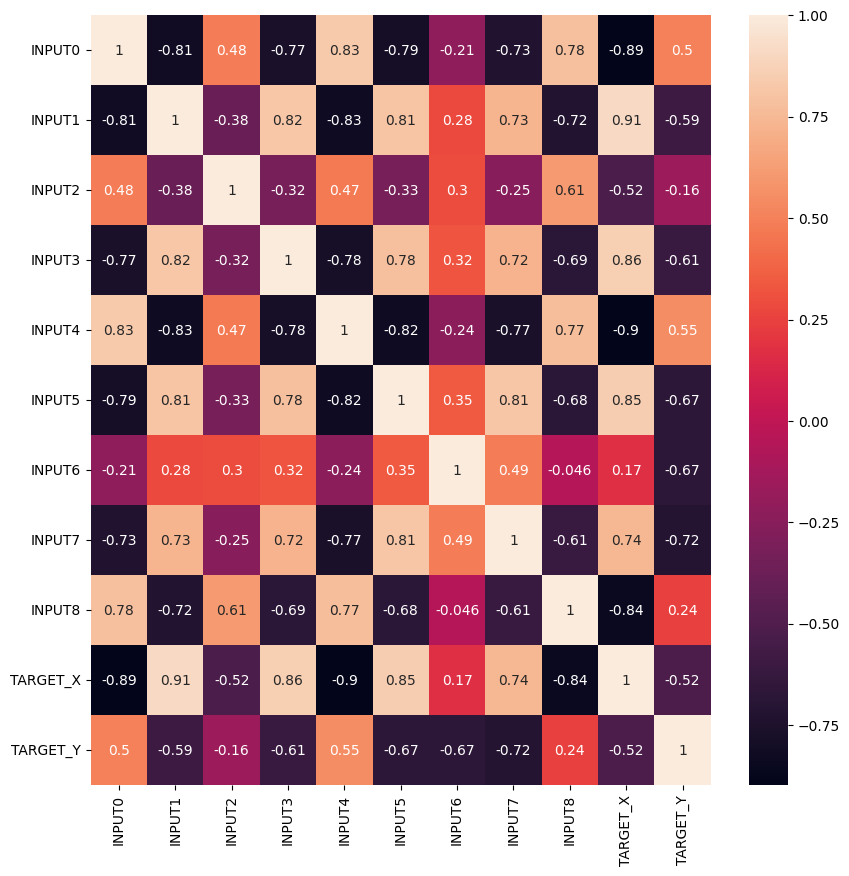

x_train  (1044, 9)
y_train  (1044, 2)
x_test  (448, 9)
y_test  (448, 2)


In [2]:
from set_extraction import x_train, y_train, x_test, y_test

# Models

In [3]:
from sklearn.metrics import make_scorer
from time import time

from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPRegressor

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
def MEE(actual, predict):

    return np.mean(np.linalg.norm(actual - predict, axis=1))
    

In [6]:
results = []

# Neural Networks

## MLPRegressor

### Grid search for parameter setting 


In [7]:
params = {  
    #'hidden_layer_sizes': [(60,), (60,50,), (60,50,40,),  (50,), (50,40,), (50,40,30,),  (40,), (40,30,), (40,30,20,)],
    'hidden_layer_sizes': [(50,), (50,50,), (50,50,50,),  (40,), (40,40,), (40,40,40,),  (30,), (30,30,), (30,30,30,)],
    'activation': ['tanh', 'relu'], 
    'solver': ['sgd'],
    'learning_rate_init':  [0.001, 0.01, 0.1], 
    'momentum': [0.0, 0.01, 0.02, 0.03], 
    'alpha': [0, 0.0001, 0.001, 0.01, 0.1],
    'n_iter_no_change': [20],
    'tol': [0],
    'batch_size': [16], # 32, 64, 128],
    #'dropout_rate': [0.1, 0.2, 0.3, 0.5]  no possibility to add dropout_rate in MLPRegressor
    }

# params = {  
#     'hidden_layer_sizes': [(50,), (50,50,),  (40,), (40,40,),  (30,), (30,30,)],
#     'activation': ['tanh', 'relu'], 
#     'solver': ['sgd'],
#     'learning_rate_init':  [0.008, 0.01, 0.02], 
#     'momentum': [0.0, 0.01, 0.03, 0.1, 0.5], 
#     'alpha': [0, 0.0001, 0.001, 0.01, 0.1],
#     'n_iter_no_change': [20],
#     'tol': [0],
#     'batch_size': [16], 
#     }

In [8]:
#hyperparameter tuning with grid search CV
n_jobs_search = -1

start=time()

mlp_search = MLPRegressor(early_stopping=True, random_state=42, max_iter=100, validation_fraction=0.2, nesterovs_momentum=False)

mlp_cv = GridSearchCV(estimator=mlp_search, param_grid=params, scoring=make_scorer(MEE, greater_is_better = False), 
                      cv=5, verbose=4, n_jobs=n_jobs_search) 
mlp_cv.fit(x_train, y_train)

print('time for grid search = {:.0f} sec'.format(time()-start))

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
time for grid search = 719 sec


In [9]:
mlp_cv.best_params_

{'activation': 'tanh',
 'alpha': 0,
 'batch_size': 16,
 'hidden_layer_sizes': (50, 50, 50),
 'learning_rate_init': 0.01,
 'momentum': 0.0,
 'n_iter_no_change': 20,
 'solver': 'sgd',
 'tol': 0}

In [10]:
# validation
mlp_cv.best_score_

-1.4627794223822963

In [11]:
best_ep_est = np.argmin(mlp_cv.best_estimator_.loss_curve_)+1

In [12]:
best_ep_est

47

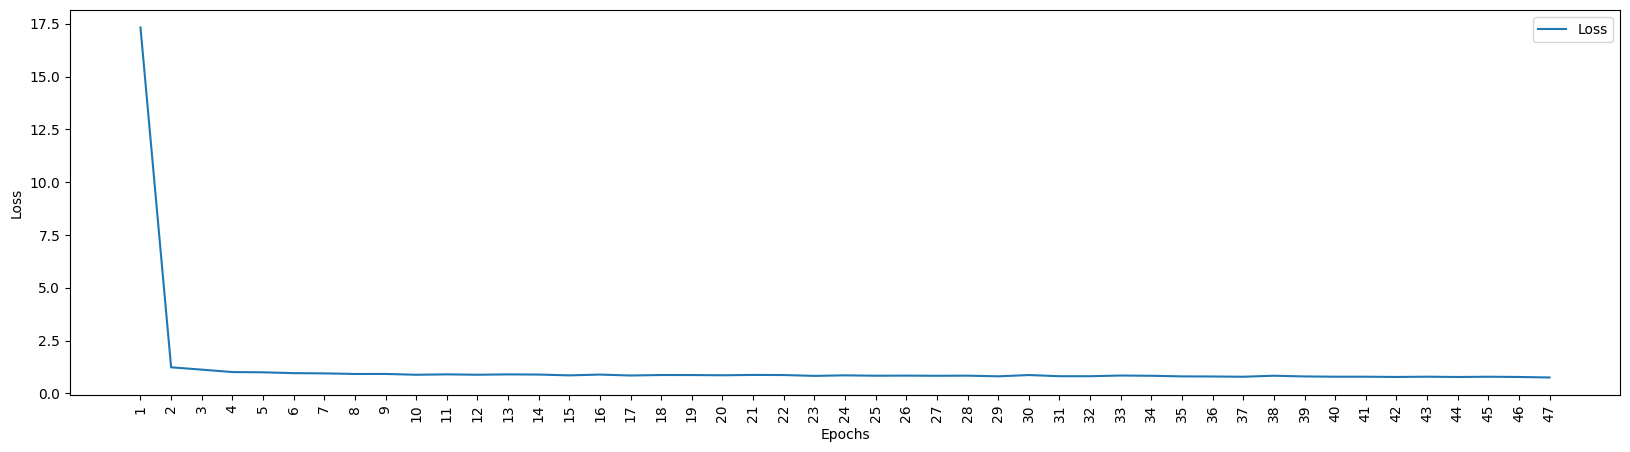

In [13]:
#Loss plot (MSE)
plt.figure(figsize = (20,5))
plt.plot(pd.DataFrame(mlp_cv.best_estimator_.loss_curve_[0:best_ep_est]), label='Loss') 
#plt.plot(pd.DataFrame(mlp_cv.best_estimator_.validation_scores_[0:best_ep_est]), label='r2', linestyle='dashed')       
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim([0,2])
plt.xticks(np.arange(len(mlp_cv.best_estimator_.loss_curve_[0:best_ep_est])), 
           np.arange(1, len(mlp_cv.best_estimator_.loss_curve_[0:best_ep_est])+1), 
           rotation=90)
plt.legend(loc = 'upper right')

In [14]:
# R2 score
mlp_cv.best_estimator_.best_validation_score_

0.9206151591361404

In [21]:
# save the model to disk
joblib.dump(mlp_cv.best_estimator_, 'cup_models/mlp.z')

['cup_models/mlp.z']

### Final model

In [22]:
mlp = joblib.load('cup_models/mlp.z')

In [23]:
mlp

MLPRegressor(activation='tanh', alpha=0, batch_size=16, early_stopping=True,
             hidden_layer_sizes=(50, 50, 50), learning_rate_init=0.01,
             max_iter=100, momentum=0.0, n_iter_no_change=20,
             nesterovs_momentum=False, random_state=42, solver='sgd', tol=0,
             validation_fraction=0.2)

In [24]:
train_pred_mlp = mlp.predict(x_train)

In [25]:
from sklearn.metrics import mean_squared_error as mse
print('MSE train set ', mse(y_train, train_pred_mlp))

MSE train set  1.6617988347551522


In [26]:
print('MEE train set ', MEE(y_train, train_pred_mlp))

MEE train set  1.41868832920698


In [27]:
test_pred_mlp = mlp.predict(x_test)

In [28]:
print('MSE test set ', mse(y_test, test_pred_mlp))

MSE test set  1.9032103824505238


In [24]:
print('MEE test set ', MEE(y_test, test_pred_mlp))

MEE test set  1.5141011419498245


[Text(0.5, 0, 'target_x'), Text(0, 0.5, 'target_y'), Text(0.5, 1.0, 'Targets')]

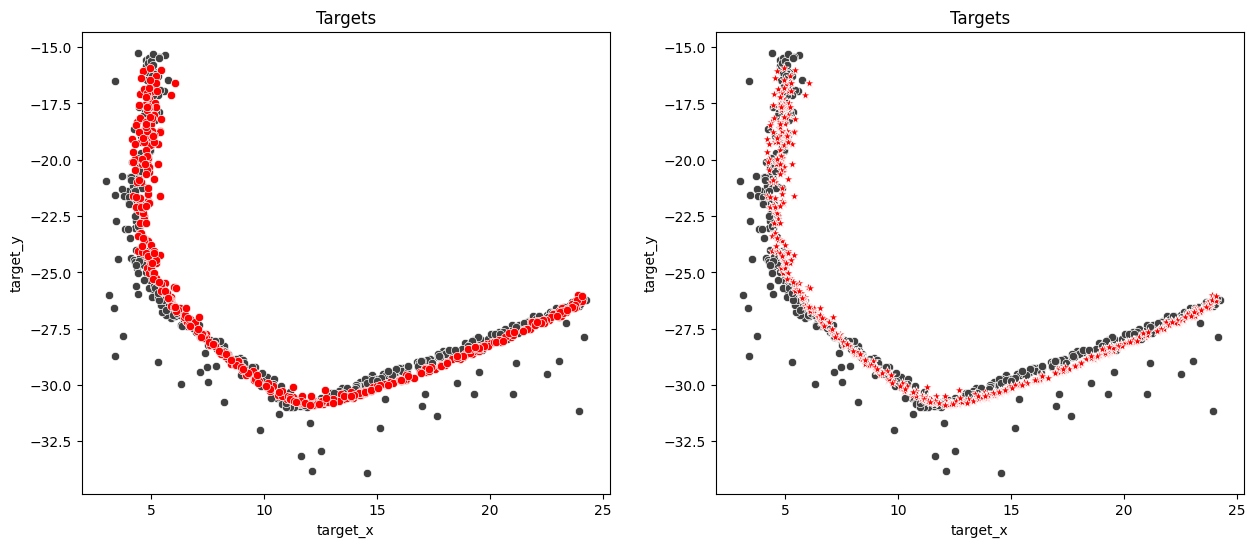

In [25]:
fig, ax = plt.subplots(1,2,figsize=(15,6))

sns.scatterplot(x=y_test[:,0],y=y_test[:,1],color='.25',ax=ax[0])
sns.scatterplot(x=test_pred_mlp[:,0],y=test_pred_mlp[:,1],color='r',ax=ax[0])
ax[0].set(xlabel='target_x',ylabel='target_y',title='Targets')

sns.scatterplot(x=y_test[:,0],y=y_test[:,1],color='.25',ax=ax[1])
sns.scatterplot(x=test_pred_mlp[:,0],y=test_pred_mlp[:,1],color='r',ax=ax[1], marker='*', s=50)
ax[1].set(xlabel='target_x',ylabel='target_y',title='Targets')

[Text(0.5, 0, 'target_x'), Text(0, 0.5, 'target_y'), Text(0.5, 1.0, 'Targets')]

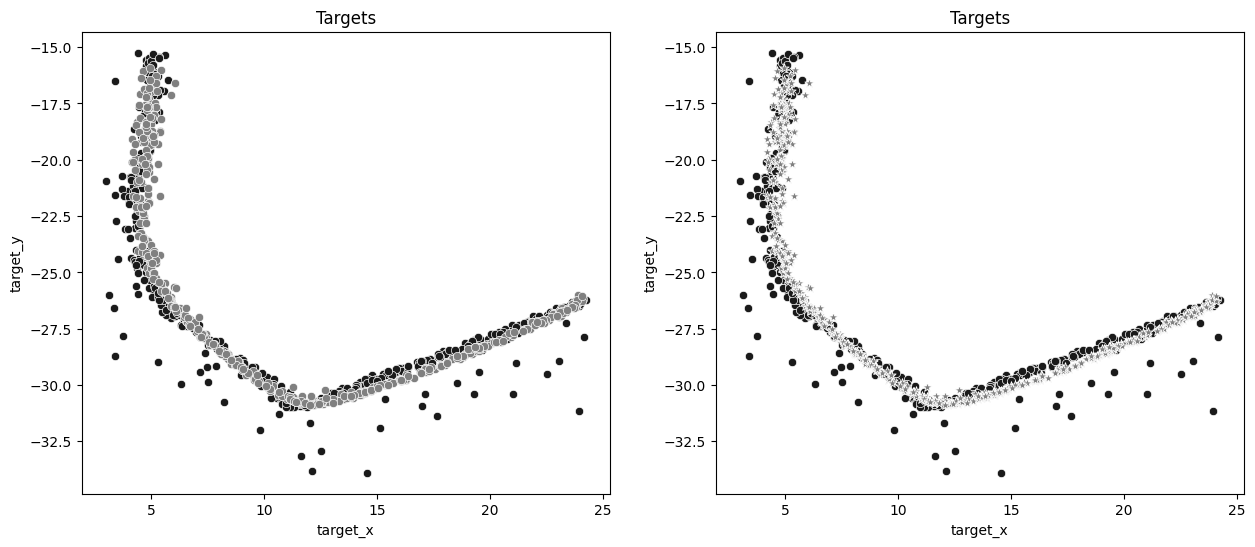

In [26]:
fig, ax = plt.subplots(1,2,figsize=(15,6))

sns.scatterplot(x=y_test[:,0],y=y_test[:,1],color='.1',ax=ax[0])
sns.scatterplot(x=test_pred_mlp[:,0],y=test_pred_mlp[:,1],color='.5',ax=ax[0])
ax[0].set(xlabel='target_x',ylabel='target_y',title='Targets')

sns.scatterplot(x=y_test[:,0],y=y_test[:,1],color='.1',ax=ax[1])
sns.scatterplot(x=test_pred_mlp[:,0],y=test_pred_mlp[:,1],color='.5',ax=ax[1], marker='*', s=50)
ax[1].set(xlabel='target_x',ylabel='target_y',title='Targets')

In [27]:
results.append(('MultilayerPerceptron train', MEE(y_train, train_pred_mlp)))
results.append(('MultilayerPerceptron validation', mlp_cv.best_score_))

# Summary

In [28]:
for i in range(len(results)):
  print(results[i])

('MultilayerPerceptron train', 1.41868832920698)
('MultilayerPerceptron validation', -1.4627794223822963)
